# HW1: Transfer Learning

Tufts CS 152 L3D, Fall 2024

Official Instructions: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html>

## Configuration

This assignment might take a while.
We recommend setting several variables here that prevent repeating long-running tasks.

In [1]:
# device = 'GPU' # TODO change to GPU if you have one (e.g. on Colab)
import torch

# Check for GPU availability
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'   # Fallback to CPU

PROB1_res_file = 'prob1_results.pkl'
PROB2_res_file = 'prob2_results.pkl'
PROB1_EXPERIMENTS = True  # Flag will skip re-running experiments if set to False
PROB1_PLOTS = True
PROB2_EXPERIMENTS = True
PROB2_PLOTS = True

# Environment setup

**Option 1: Colab**
To use this notebook with Google Colab, you will need an account and Google Drive storage (free tier just fine)

Please be sure you are *logged in* and have given requisite permission to access Drive to Google Colab.

The lines below will:

* Make folders called `CS152L3D_2024f/HW1/` in your google drive
* Clone the HW1 starter code repository there
* Note: Colab expects *this notebook* (or any notebook) will be in `Colab Notebooks/`.

That will let us use the starter code in this notebook.

**Option 2: Local**

You can also try to use your local machine (but if you don't have a GPU, this may be slow and painful.
If you choose this route, the lines below specific to Colab will just be skipped, and nothing will be done.

In [2]:
import sys
import os

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    COLAB = True
except ImportError:
    COLAB = False

In [4]:
if COLAB:
    if not os.path.exists(os.path.join('/content/drive/MyDrive/', 'CS152L3D_2024f')):
        !cd /content/drive/MyDrive/ && mkdir CS152L3D_2024f


In [5]:
# Move notebook working directory into the folder
if COLAB:
    %cd /content/drive/MyDrive/CS152L3D_2024f/

    # Clone the repo
    if not os.path.exists('cs152l3d-24f-assignments/hw1/'):
      !git clone https://github.com/tufts-ml-courses/cs152l3d-24f-assignments

    # cd into repo
    %cd cs152l3d-24f-assignments/hw1/

Check for success. We should be able to see files like

* model.py
* data_utils.py

In [6]:
!ls

README.md                      hw1submission.zip
__pycache__                    l3d_24f_cpu.yml
best_model.pth                 l3d_24f_cuda.yml
best_model_info.pkl            models.py
birdsnap10                     resnet10-1253-88a5961b.pth
birdsnap10_224x224only.zip     resnet10_cub-2777-4525b593.pth
colab_requirements.txt         resnet26-0849-4bfbc640.pth
data_utils.py                  resnet26_cub-2316-599ab467.pth
hw1.ipynb                      train.py
hw1_template.tex


In [7]:
if COLAB:
    try:
        import torchinfo
        import pytorchcv
    except ImportError:
        rstr = '''
            torchinfo
            pytorchcv
            '''
        with open('colab_requirements.txt', 'w') as f:
            f.write(rstr)
        !pip install -r colab_requirements.txt
        import torchinfo
        import pytorchcv
        

In [8]:
DATA_DIR = os.environ.get('DATA_DIR', os.path.abspath('./birdsnap10'))
print(DATA_DIR)


/Users/kerwin/Tufts/FALL 2024/CS152 Learning from limited labeled data/CS152L3D_2024f/cs152l3d-24f-assignments/hw1/birdsnap10


In [9]:
if not os.path.exists(DATA_DIR):
    !unzip birdsnap10_224x224only.zip

In [10]:
# Show contents of train set
!ls $DATA_DIR/train/

ls: /Users/kerwin/Tufts/FALL: No such file or directory
ls: 2024/CS152: No such file or directory
ls: Learning: No such file or directory
ls: data/CS152L3D_2024f/cs152l3d-24f-assignments/hw1/birdsnap10/train/: No such file or directory
ls: from: No such file or directory
ls: labeled: No such file or directory
ls: limited: No such file or directory


# Import Libraries

In [11]:
# Import third-party library modules
import json
import pickle
import itertools
import tqdm

In [12]:
import numpy as np
import pandas as pd

In [13]:
import torchinfo
import pytorchcv
import torch
import torchvision

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8') # pretty matplotlib plots
sns.set('notebook', style='whitegrid', font_scale=1.25)

# Import starter code modules from local files

Use **autoreload** so that any changes to these local files will be automatically reloaded into this nb

In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
# running code locally so need paths to files
import importlib.util
import sys
import os

folder_path = os.path.abspath('')

data_utils_path = os.path.join(folder_path, 'data_utils.py')
spec_data_utils = importlib.util.spec_from_file_location("data_utils", data_utils_path)
data_utils = importlib.util.module_from_spec(spec_data_utils)
sys.modules["data_utils"] = data_utils
spec_data_utils.loader.exec_module(data_utils)

models_path = os.path.join(folder_path, 'models.py')
spec_models = importlib.util.spec_from_file_location("models", models_path)
models = importlib.util.module_from_spec(spec_models)
sys.modules["models"] = models
spec_models.loader.exec_module(models)

train_path = os.path.join(folder_path, 'train.py')
spec_train = importlib.util.spec_from_file_location("train", train_path)
train = importlib.util.module_from_spec(spec_train)
sys.modules["train"] = train
spec_train.loader.exec_module(train)


In [17]:
# Import utils from provided local starter code files
import data_utils
import models
import train

In [18]:
# Re-run this cell if you've made changes to your local file, but they aren't reflected in current nb kernel state
import importlib
importlib.reload(models);
importlib.reload(train);

# Show basic ResNet10 architecture

Load ResNet10. All layers trainable by default.

In [19]:
resnet10_in = models.PretrainedResNetForBirdSnap10(
    src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1)

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


Pretty-print layer-by-layer info

In [20]:
torchinfo.summary(resnet10_in, (1, 3, 224, 224),
                  row_settings=['var_names'],
                  col_names=["output_size", "num_params"],
                  col_width=18)

Layer (type (var_name))                                           Output Shape       Param #
PretrainedResNetForBirdSnap10 (PretrainedResNetForBirdSnap10)     [1, 10]            --
├─ResNet (model)                                                  [1, 10]            --
│    └─Sequential (features)                                      [1, 512, 1, 1]     --
│    │    └─ResInitBlock (init_block)                             [1, 64, 56, 56]    (9,536)
│    │    └─Sequential (stage1)                                   [1, 64, 56, 56]    (73,984)
│    │    └─Sequential (stage2)                                   [1, 128, 28, 28]   (230,144)
│    │    └─Sequential (stage3)                                   [1, 256, 14, 14]   (919,040)
│    │    └─Sequential (stage4)                                   [1, 512, 7, 7]     (3,673,088)
│    │    └─AvgPool2d (final_pool)                                [1, 512, 1, 1]     --
│    └─Linear (output)                                            [1, 10]        

# Load dataset

In [21]:
# Verify data has been extracted correctly and is accessible to load in PyTorch
(data_utils.BirdsnapDataset(DATA_DIR))

Dataset BirdsnapDataset
    Number of datapoints: 640
    Root location: /Users/kerwin/Tufts/FALL 2024/CS152 Learning from limited labeled data/CS152L3D_2024f/cs152l3d-24f-assignments/hw1/birdsnap10

In [22]:
train_loader, val_loader, test_loader = data_utils.make_birdsnap_data_loaders(DATA_DIR)

splitname  0  1  2  3  4  5  6  7  8  9
    train 40 40 40 40 40 40 40 40 40 40
    valid 10 10 10 10 10 10 10 10 10 10
     test 14 14 14 14 14 14 14 14 14 14


# Problem 1 Implementation Tasks

In separate windows, you'll need to edit:

* models.py, see task (i) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>
* train.py, see tasks (ii, iii, iv) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>

Any edits to these files should *automatically* be reflected here in your active nb session, since we used **autoreload** above

Finally, as task (v), complete the implementation of `eval_acc` here to evaluate accuracy on test data

In [23]:
def eval_acc(model, device, test_loader):
    model.to(device)
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits_BC = model(x)
            _, predicted = torch.max(logits_BC, 1)
            correct += (predicted == y).sum().item()


    return correct / len(test_loader.dataset) 

In [24]:
print(test_loader)
print(len(test_loader))
print(len(test_loader.dataset))

3
140


In [25]:
print(train_loader)
print(len(train_loader))
print(len(train_loader.dataset))
print(train_loader.batch_size)

7
400
64


# Problem 1 Experiments

We'll now try to fit models for 2 archs (RN10, RN26) and 2 srcdatasets (ImageNet, CUB)

For each one, we'll

* keep n_trainable_layers = 1 ("last layer only" or "linear probing")
* Try to find reasonable settings of learning rate (lr), l2 penalty strength (l2pen_mag), and random seed (controls initialization and data order)

**TODO: Last-layer training of ResNet10 from ImageNet1k.**

Need to find good hyperparameters (seed, lr, l2penalty magnitude, n_epochs)

Don't peek at test, just use validation to tune.

In [ ]:
if PROB1_EXPERIMENTS:
    seed = 606
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1, seed=seed)

    best_model_resnet10_1k, best_info_resnet10_1k = train.train_model(resnet10_in, device, train_loader, val_loader,
        n_epochs=35,
        lr=0.02,
        l2pen_mag = 0.1,
        data_order_seed=seed,
        )


Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


  6%|▌         | 2/36 [00:03<00:53,  1.57s/it, tr_xent=6.24, tr_err=0.792, va_xent=5.42, va_err=0.76, batch_done=2]

# Diagnostic plot: Error/loss vs epoch

The plot below is just a demo of what you can plot. Values won't represent correct operation of model training until you run the code implementation tasks, and start training for longer (adjust n_epochs > 15).

FYI: good practices already implemented info dict returned by train_model

* Report perf on val on given initial model (epoch=0), before making any updates
* Train perf metrics only kick in for epoch 1 and later (when we are doing updates)

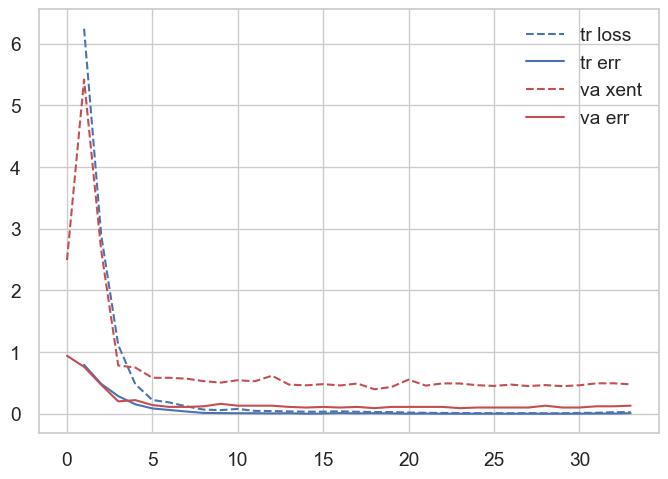

In [29]:
plt.plot(best_info_resnet10_1k['epochs'], best_info_resnet10_1k['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_resnet10_1k['epochs'], best_info_resnet10_1k['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_resnet10_1k['epochs'], best_info_resnet10_1k['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_resnet10_1k['epochs'], best_info_resnet10_1k['va']['err'], '-', color='r', label='va err')
plt.legend();

**Pro Tip:** Consider storing your "best" runs to disk, using code like below

In [30]:
# if os.path.exists(PROB1_res_file):
#     with open(PROB1_res_file, 'rb') as f:
#         results = pickle.load(f)
# else:
#     results = dict()

# results[(src_dataset, arch)] = best_model, best_info

# with open(PROB1_res_file, 'w') as f:
#     f.save(results)


**TODO** repeat the above for each config in ('ResNet10', 'ResNet26') and ('ImageNet1k', 'CUB')

In [32]:
# DONE do tuning expts for Resnet10, CUB
if PROB1_EXPERIMENTS:
    seed = 606
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='CUB', arch='ResNet10', n_trainable_layers=1, seed=seed)

    best_model_resnet10, best_info_resnet10 = train.train_model(resnet10_in, device, train_loader, val_loader,
        n_epochs=35,
        lr=0.02,
        l2pen_mag = 0.1,
        data_order_seed=seed,
        )


Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 81%|████████  | 29/36 [00:42<00:10,  1.47s/it, tr_xent=0.13, tr_err=0.0175, va_xent=1.21, va_err=0.31, batch_done=7]  

Stopped early.
Finished after epoch 29, best epoch=14
best va_xent 0.967
best tr_err 0.068
best va_err 0.270


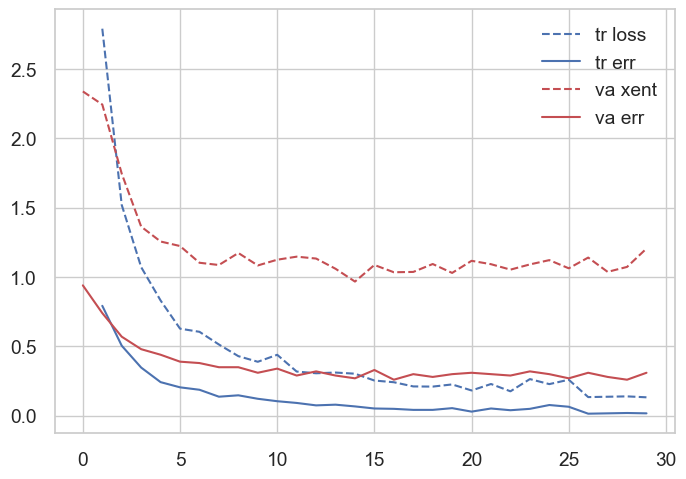

In [53]:
plt.plot(best_info_resnet10['epochs'], best_info_resnet10['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_resnet10['epochs'], best_info_resnet10['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_resnet10['epochs'], best_info_resnet10['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_resnet10['epochs'], best_info_resnet10['va']['err'], '-', color='r', label='va err')
plt.legend();

In [54]:
# DONE do tuning expts for Resnet26, ImageNet1k
if PROB1_EXPERIMENTS:
    seed = 606
    resnet26_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet26', n_trainable_layers=1, seed=seed)

    best_model_resnet26_1k, best_info_resnet26_1k = train.train_model(resnet26_in, device, train_loader, val_loader,
        n_epochs=35,
        lr=0.02,
        l2pen_mag = 0.1,
        data_order_seed=seed,
        )


Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 58%|█████▊    | 21/36 [00:56<00:40,  2.71s/it, tr_xent=0.0158, tr_err=0, va_xent=0.699, va_err=0.18, batch_done=7]     

Stopped early.
Finished after epoch 21, best epoch=6
best va_xent 0.606
best tr_err 0.028
best va_err 0.150


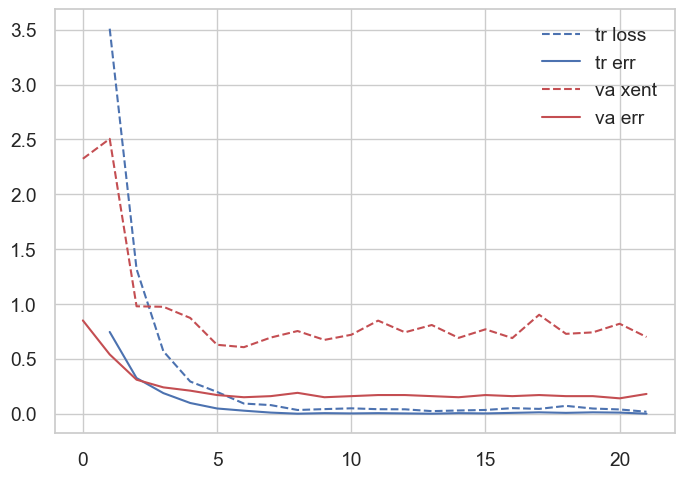

In [55]:
plt.plot(best_info_resnet26_1k['epochs'], best_info_resnet26_1k['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_resnet26_1k['epochs'], best_info_resnet26_1k['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_resnet26_1k['epochs'], best_info_resnet26_1k['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_resnet26_1k['epochs'], best_info_resnet26_1k['va']['err'], '-', color='r', label='va err')
plt.legend();

In [56]:
# TODO do tuning expts for Resnet26, CUB
if PROB1_EXPERIMENTS:
    seed = 606
    resnet26_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='CUB', arch='ResNet26', n_trainable_layers=1, seed=seed)

    best_model_resnet26_cub, best_info_resnet26_cub = train.train_model(resnet26_in, device, train_loader, val_loader,
        n_epochs=35,
        lr=0.02,
        l2pen_mag = 0.11,
        data_order_seed=seed,
        )


Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 67%|██████▋   | 24/36 [01:05<00:32,  2.71s/it, tr_xent=0.148, tr_err=0.04, va_xent=1.02, va_err=0.24, batch_done=7]   

Stopped early.
Finished after epoch 24, best epoch=9
best va_xent 0.791
best tr_err 0.062
best va_err 0.210


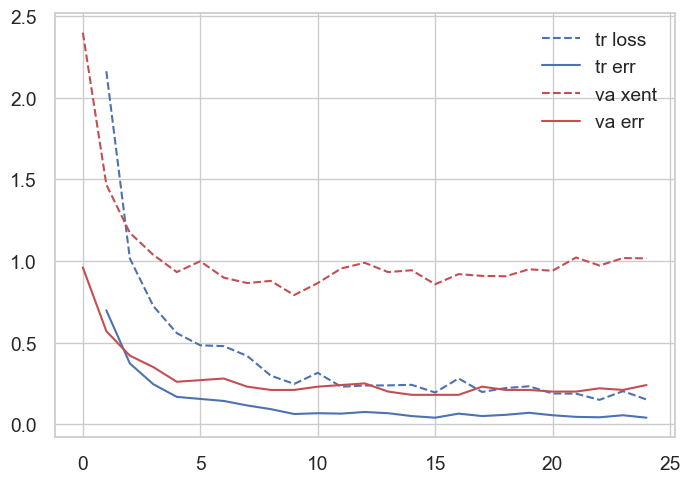

In [57]:
plt.plot(best_info_resnet26_cub['epochs'], best_info_resnet26_cub['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_resnet26_cub['epochs'], best_info_resnet26_cub['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_resnet26_cub['epochs'], best_info_resnet26_cub['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_resnet26_cub['epochs'], best_info_resnet26_cub['va']['err'], '-', color='r', label='va err')
plt.legend();

# Problem 1 Analysis and Plotting

In [58]:
# # Create dummy results so we can show what kind of plots we want
dummy_result = {}

eps_1k = np.arange(33)  
# Ensure that metric arrays have the same length as their respective epochs
dummy_result[('ResNet10', 'ImageNet1k')] = dict(
    lr=0.02,
    l2pen_mag=0.1,
    seed=606,
    epochs=eps_1k,
    tr=dict(
        loss=best_info_resnet10_1k['tr']['loss'][:len(eps_1k)],  
        xent=best_info_resnet10_1k['tr']['xent'][:len(eps_1k)],
        err=best_info_resnet10_1k['tr']['err'][:len(eps_1k)],
    ),
    va=dict(
        xent=best_info_resnet10_1k['va']['xent'][:len(eps_1k)], 
        err=best_info_resnet10_1k['va']['err'][:len(eps_1k)],
    ),
    best_epoch=18,
    best_va_loss=0.396,
)


eps_cub = np.arange(29) 
# Ensure that metric arrays have the same length as their respective epochs
dummy_result[('ResNet10', 'CUB')] = dict(
    lr=0.02,
    l2pen_mag=0.1,
    seed=606,
    epochs=eps_cub,
    tr=dict(
        loss=best_info_resnet10['tr']['loss'][:len(eps_cub)], 
        xent=best_info_resnet10['tr']['xent'][:len(eps_cub)],
        err=best_info_resnet10['tr']['err'][:len(eps_cub)],
    ),
    va=dict(
        xent=best_info_resnet10['va']['xent'][:len(eps_cub)],  
        err=best_info_resnet10['va']['err'][:len(eps_cub)],
    ),
    best_epoch=14,  # Adjusted based on actual data
    best_va_loss=0.967,
)

## Figure 1a: Loss over Epochs

Starter code notebook indicates style of plot desired.

**TODO** Your job is to make sure the plot shows your *real* results, not our dummy results.

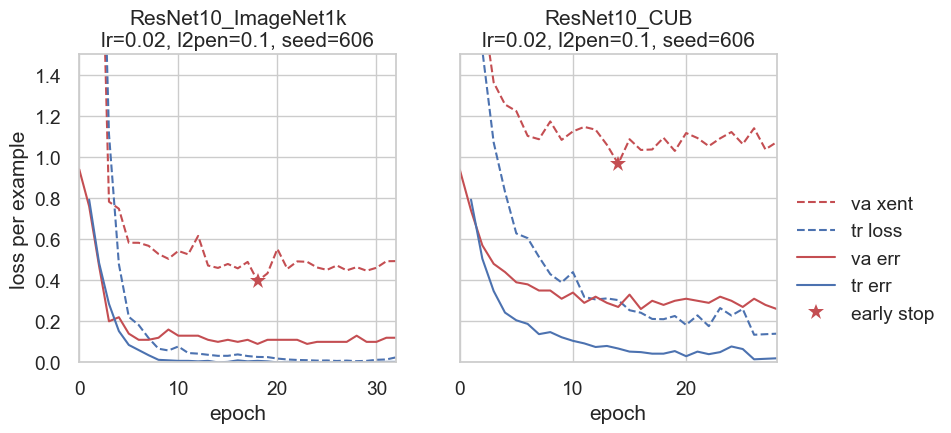

In [59]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=False)

for panel_id, (arch, src_dataset) in enumerate([
        ('ResNet10','ImageNet1k'),
        ('ResNet10','CUB'),
        ]):
    ax = axgrid[panel_id]
    key = (arch, src_dataset)
    info = dummy_result[key]
    ax.plot(info['epochs'], info['va']['xent'], '--', color='r', label='va xent')
    ax.plot(info['epochs'], info['tr']['loss'], '--', color='b', label='tr loss')
    ax.plot(info['epochs'], info['va']['err'], label='va err', color='r')
    ax.plot(info['epochs'], info['tr']['err'], label='tr err', color='b')
    ax.plot(info['best_epoch'], info['best_va_loss'], '*', color='r', markersize=12, label='early stop')
    ax.set_xlabel('epoch')
    if panel_id == 0:
        ax.set_ylabel('loss per example')
    lr = info['lr']
    l2pen = info['l2pen_mag']
    seed = info['seed']
    ax.set_title(f'{arch}_{src_dataset}\nlr={lr}, l2pen={l2pen}, seed={seed}')
    ax.set_xlim([-0.001, max(info['epochs'])])

ax.set_ylim([0.0, 1.5]);
ax.legend(bbox_to_anchor=(1.55, 0.6));

## Figure 1b: Target Acc vs Source Acc

**TODO** Lookup source task accuracy (use top1 if needed) from pytorch cv webpage: https://pypi.org/project/pytorchcv/


In [60]:
src_acc = {}
src_acc[('ResNet10', 'ImageNet1k')] = 0.68 
src_acc[('ResNet26', 'ImageNet1k')] = 0.74 

src_acc[('ResNet10', 'CUB')] = 0.72 
src_acc[('ResNet26', 'CUB')] = 0.77 

**TODO** Measure your best model accuracy using provided test_loader and `eval_acc` function, record values here

In [61]:
tar_acc = {}

tar_acc[('ResNet10', 'ImageNet1k')] = eval_acc(best_model_resnet10_1k, device, test_loader)
tar_acc[('ResNet26', 'ImageNet1k')] = eval_acc(best_model_resnet26_1k, device, test_loader)  

tar_acc[('ResNet10', 'CUB')] = eval_acc(best_model_resnet10, device, test_loader)
tar_acc[('ResNet26', 'CUB')] = eval_acc(best_model_resnet26_cub, device, test_loader)

# Print the updated target accuracies
print("Target Accuracies:")
print(tar_acc)

Target Accuracies:
{('ResNet10', 'ImageNet1k'): 0.7785714285714286, ('ResNet26', 'ImageNet1k'): 0.8, ('ResNet10', 'CUB'): 0.5142857142857142, ('ResNet26', 'CUB'): 0.5142857142857142}


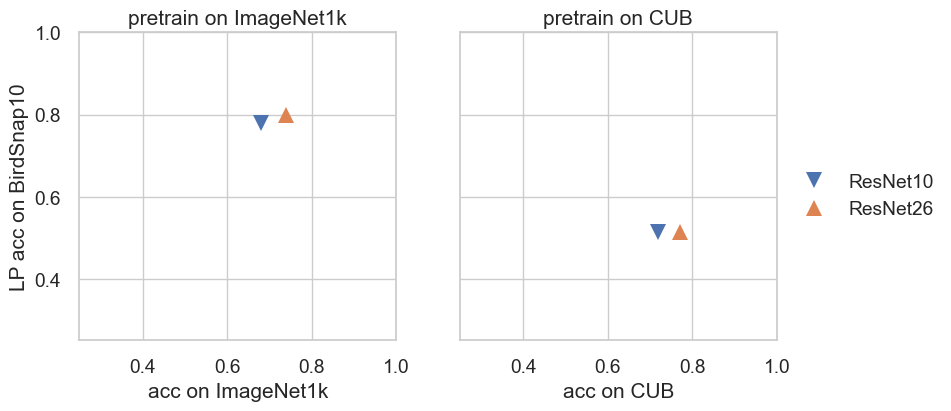

In [62]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

arch_list = ['ResNet10', 'ResNet26']
srcdata_list = ['ImageNet1k', 'CUB']

for (arch, src_dataset) in itertools.product(arch_list, srcdata_list):
    if src_dataset.count("ImageNet"):
        panel_id = 0
    else:
        panel_id = 1
    ax = axgrid[panel_id]
    ax.set_title("pretrain on " + src_dataset)
    key = "{arch}_{src_dataset}".format(arch=arch, src_dataset=src_dataset)
    cur_target_acc = tar_acc[(arch, src_dataset)]
    cur_src_acc = src_acc[(arch, src_dataset)]
    ax.plot(cur_src_acc, cur_target_acc, 'v' if arch.count('10') else '^', label=arch, markersize=12)
    ax.set_xlim([0.25, 1.0]); ax.set_xticks([.4, .6, .8, 1]);
    ax.set_ylim([0.25, 1.0]); ax.set_yticks([.4, .6, .8, 1]);
    ax.set_xlabel(f"acc on {src_dataset}");
    if panel_id == 0:
        ax.set_ylabel(f"LP acc on BirdSnap10");
plt.legend(bbox_to_anchor=(1.55, 0.6));

# Problem 2 Experiments

TODO Implement LP-then-FT, via repeated calls to **train_model**

* LP phase should use n_trainable_layers=1 (about 5000 trainable params)
* FT phase should use n_trainable_layers=3 (about 100000 trainable params)

In [79]:
if PROB1_EXPERIMENTS:
    seed = 606
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1, seed=seed)

    best_model_resnet10_1k, best_info_resnet10_1k = train.train_model(resnet10_in, device, train_loader, val_loader,
        n_epochs=30,
        lr=0.02,
        l2pen_mag = 0.1,
        data_order_seed=seed,
        )

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:49<00:00,  1.59s/it, tr_xent=0.0109, tr_err=0, va_xent=0.461, va_err=0.1, batch_done=7]      

Finished after epoch 30, best epoch=18
best va_xent 0.396
best tr_err 0.007
best va_err 0.090


In [80]:
import copy

ft_seed = 606

resnet10_ft = models.PretrainedResNetForBirdSnap10(
    src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=3, seed=ft_seed)

resnet10_ft.load_state_dict(copy.deepcopy(best_model_resnet10_1k.state_dict()))

# Fine-tune the model with the new hyperparameters
best_model_ft, best_info_ft = train.train_model(
    resnet10_ft, device, train_loader, val_loader,
    n_epochs=40,
    lr=0.001,
    l2pen_mag=0.4,
    data_order_seed=ft_seed
)

Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.


 44%|████▍     | 18/41 [00:33<00:42,  1.85s/it, tr_xent=0.000743, tr_err=0, va_xent=0.418, va_err=0.09, batch_done=7]  

Stopped early.
Finished after epoch 18, best epoch=3
best va_xent 0.376
best tr_err 0.000
best va_err 0.120


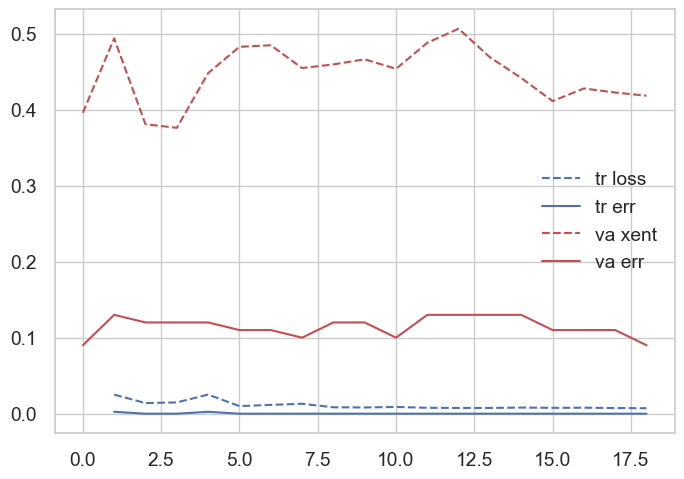

In [81]:
plt.plot(best_info_ft['epochs'], best_info_ft['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_ft['epochs'], best_info_ft['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_ft['epochs'], best_info_ft['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_ft['epochs'], best_info_ft['va']['err'], '-', color='r', label='va err')
plt.legend();

In [82]:
ft_acc = eval_acc(best_model_ft, device, test_loader)
print(ft_acc)

0.7857142857142857


In [83]:
# eps = np.arange(20)

P2_dummy_result = {}

# Phase 1, copy hard work from Problem 1
P2_dummy_result[('ResNet10', 'ImageNet1k','phase1')] = dummy_result[('ResNet10', 'ImageNet1k')]

eps_ft = np.arange(18)
P2_dummy_result[('ResNet10', 'ImageNet1k','phase2')] = dict(
    lr = 0.001,
    l2pen_mag = 0.1,
    seed = 606,
    epochs=np.arange(18),
    tr=dict(
        loss=best_info_ft['tr']['loss'][:len(eps_ft)],
        err=best_info_ft['tr']['err'][:len(eps_ft)]
    ),
    va=dict(
        xent=best_info_ft['va']['xent'][:len(eps_ft)],
        err=best_info_ft['va']['err'][:len(eps_ft)],
    ),
    best_epoch=3,
    best_va_loss=0.376,
    test_acc=0.78571,
)

## Figure 2a: Trace plots for LP then FT

We'll be looking for:

* Clear continuity in val set perf (the FT phase started at val set err rate/xent of the best LP checkpoint)
* Some kind of improvement in the FT phase, at least on train

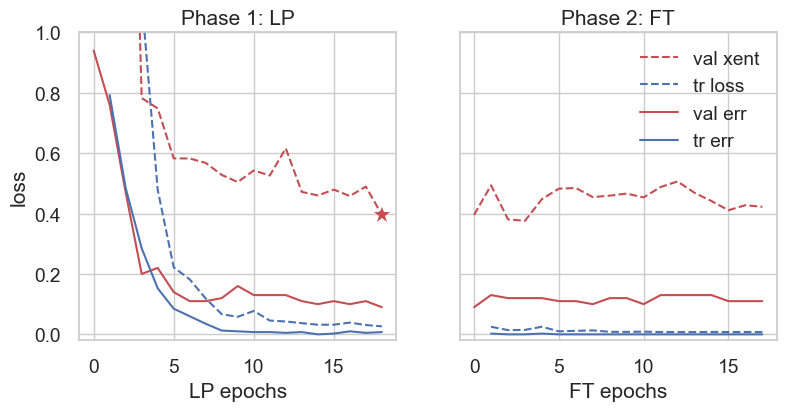

In [84]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

LPbest = P2_dummy_result[('ResNet10', 'ImageNet1k', 'phase1')]
FTbest = P2_dummy_result[('ResNet10', 'ImageNet1k', 'phase2')]

# Only show LP phase until early stop occurs
eps = [e for e in LPbest['epochs'] if e <= LPbest['best_epoch']]
axgrid[0].plot(eps, LPbest['va']['xent'][:len(eps)], '--', color='r', label='val xent')
axgrid[0].plot(eps, LPbest['tr']['loss'][:len(eps)], '--', color='b')
axgrid[0].plot(eps, LPbest['va']['err'][:len(eps)], color='r', label='val')
axgrid[0].plot(eps, LPbest['tr']['err'][:len(eps)], '-', color='b')
axgrid[0].plot(LPbest['best_epoch'], LPbest['best_va_loss'], '*', color='r', markersize=12);
axgrid[0].set_title("Phase 1: LP");
axgrid[0].set_xlabel("LP epochs");
axgrid[0].set_ylabel("loss");

FTeps = FTbest['epochs']
axgrid[1].plot(FTeps, FTbest['va']['xent'], '--', color='r', label='val xent')
axgrid[1].plot(FTeps, FTbest['tr']['loss'], '--', color='b', label='tr loss')
axgrid[1].plot(FTeps, FTbest['va']['err'], '-', color='r', label='val err')
axgrid[1].plot(FTeps, FTbest['tr']['err'], '-', color='b', label='tr err')
axgrid[1].set_title("Phase 2: FT");
axgrid[1].set_ylim([-0.02, 1.]);
axgrid[1].set_xlabel('FT epochs');
axgrid[1].legend(loc='upper right');


## Problem 2b: Report test-set acc for both the phase1 and phase 2

These numbers will be presented in your report.

In [85]:
# DONE compute test acc after the LP phase
lp_acc = eval_acc(best_model_resnet10_1k, device, test_loader)
print(lp_acc)

0.7785714285714286


In [86]:
# DONE compute test acc after the FT-3 phase
ft_3_acc = eval_acc(best_model_ft, device, test_loader)
print(ft_3_acc)

0.7857142857142857
